In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

In [2]:
data = pd.read_csv("Churn_Modelling.csv",index_col=0)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<Axes: xlabel='Exited', ylabel='count'>

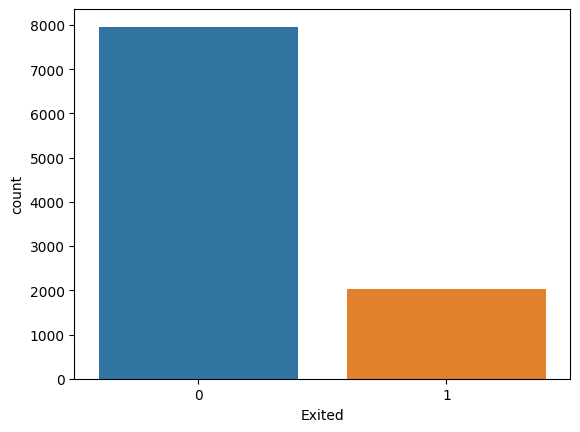

In [3]:
sns.countplot(x='Exited', data=data)
## Clearly the dataset is imbalanced, Selection of proper evaluation metrics would help to counter this.
## Recall would be much better option as it penalises false negative.

<Axes: xlabel='Gender', ylabel='count'>

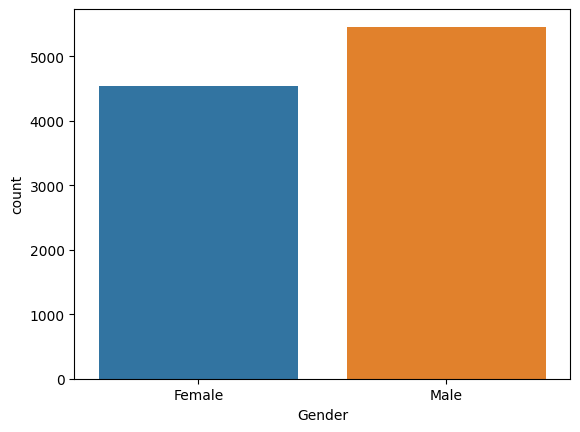

In [4]:
sns.countplot(x='Gender', data=data)
## A workable distribution

In [5]:
## Converting data into categorical data
#data['Geography']=data['Geography'].astype('category')
#data['Gender']=data['Gender'].astype('category')
data.drop(['Surname','CustomerId'],axis=1,inplace=True)

In [6]:
geography = pd.get_dummies(data['Geography'], drop_first=True)
gender = pd.get_dummies(data['Gender'], drop_first=True)
data = pd.concat([data, geography, gender], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X = data.drop(['Exited', 'Geography', 'Gender'], axis=1)
y = data['Exited']

### Balancing the dataset using smote
from imblearn.over_sampling  import RandomOverSampler
smoteOver = RandomOverSampler(sampling_strategy=1)
X, y = smoteOver.fit_resample(X,y)
#########################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, stratify=y)

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()

model.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu', input_dim=11))
model.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the ANN to the Training set
model_history = model.fit(X_train, y_train, batch_size=10, validation_split=0.33, epochs=100,verbose=0)



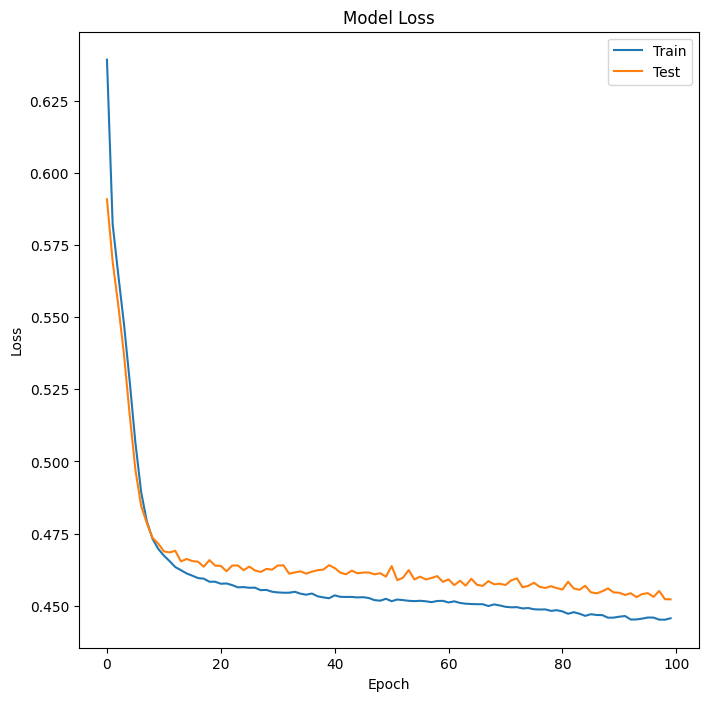

In [10]:

plt.figure(figsize=(8,8))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [11]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)

100/100 [==============================] - 0s 2ms/step


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1593
           1       0.79      0.76      0.78      1593

    accuracy                           0.78      3186
   macro avg       0.78      0.78      0.78      3186
weighted avg       0.78      0.78      0.78      3186



### Explaining the model

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


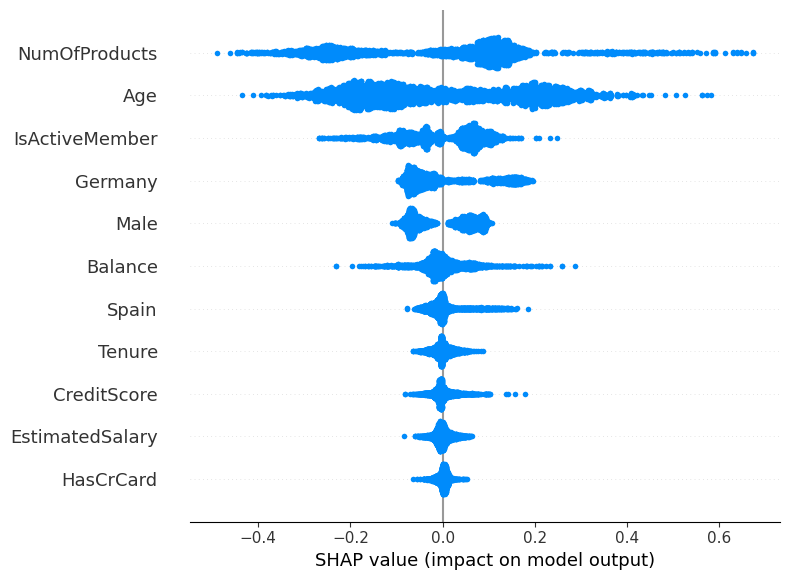

In [54]:
from shap import DeepExplainer,summary_plot
exp=DeepExplainer(model, X_test)
values=exp.shap_values(X_test)[0]
base_value=exp.expected_value.numpy()[0]
summary_plot(values,feature_names=X.columns)

## The following plot showa that the biggest feature/ the most important feature in deciding weather a 
# customer will leave the bank or not is 'NumberofProducts' he/she is using follows by 'age' and 
# 'if_an_active_member'